# Description

Image segmentation using EM: You can segment an image using a clustering method - each segment is the cluster center to which a pixel belongs. In this task I will represent an image pixel by its r, g, and b values. Apply the EM algorithm to the mixture of normal distributions model (also called Gaussian Mixture Model or GMM) to cluster image pixels, then segment the image by mapping each pixel to the cluster center with the highest value of the posterior probability for that pixel. 

Rather than using a package, I will **plement the EM algorithm by myself** and display the results for some images

---

# Imports

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from skimage import io

from scipy.special import logsumexp
from sklearn.cluster import KMeans

import PIL.Image
import IPython.display

# Implementing the Gaussian Mixture Model
I will implement and describe every function, one at a time, and combine everything at the end

## The Expectation Step
I worte a function `find_H` that calculates the

$$H_{i,j} := -\frac{1}{2} \bigg[ (\mathbf{x}_i-\mathbf{\mu}_j)^T(\mathbf{x}_i-\mathbf{\mu}_j) \bigg]$$
 
matrix, and takes the following arguments as input:

- `X`: A numpy array of the shape (N,d) where N is the number of pixels in the image (i.e., number of data points in this problem) and d is the number of fundamental pixel colors (i.e., dimension of the data space in this problem).
- `mu`: A numpy array of the shape (K,d) where K is the target number of clusters for clustering and d is the number of colors (i.e., dimension of the data space in this problem).

The function returns the numpy array H with the shape of (N, K) and np.float64 data type.

In [5]:
def find_H(X, mu):
    N = X.shape[0]
    d = X.shape[1]
    K = mu.shape[0]
    
    H1 = np.square(X) @ np.ones((d, K))
    H2 = np.ones((N, d)) @ np.square(mu).T
    H3 = X @ mu.T
    H = -(1/2) * (H1 + H2 - 2*H3)
    
    return H

This function find_logW calculates the  log𝑊𝑖,𝑗  matrix, and takes the following arguments as input:

- `H`: A numpy array of the shape (N,K) where N is the number of pixels in the image and K is the number of clusters. This is the supposed output of the find_H function above
- `log_pi`: A numpy array of the shape (K,1) where K is the number of clusters

Function returns the numpy array logW with the shape of (N, K) whose  𝑖𝑡ℎ  row and  𝑗𝑡ℎ  column should be

$$\log W_{i,j} := \log\bigg(\frac{\pi_j \exp\bigg(-\frac{1}{2} \bigg[ (\mathbf{x}_i-\mathbf{\mu}_j)^T(\mathbf{x}_i-\mathbf{\mu}_j) \bigg]\bigg)}{\sum_{l=1}^{K} \pi_l \exp\bigg(-\frac{1}{2} \bigg[ (\mathbf{x}_i-\mathbf{\mu}_l)^T(\mathbf{x}_i-\mathbf{\mu}_l) \bigg]\bigg)}\bigg)$$

In [6]:
def find_logW(H, log_pi):
    num = H + log_pi.T
    denom = logsumexp(num, axis=1).reshape(-1,1)
    logW = num - denom
    
    return logW

## The Maximization Step

Function `update_logpi` computes the $\log \pi^{\text{new}}$ vector, and takes the following argument as input:

1. `logW`: A numpy array of the shape `(N,K)` where `N` is the number of pixels in the image and `K` is the number of clusters. This is the supposed output of the `find_logW` function

Function returns the numpy array `log_pi` with the shape of `(K, 1)` whose $j^{th}$ element should be

$$\log \pi^{\text{new}}_{j} := \log \frac{\sum_{i=1}^N W_{i,j}}{N}$$

In [7]:
def update_logpi(logW):
    N, K = logW.shape

    log_pi = (logsumexp(logW.T, axis=1) - np.log(N)).reshape(-1, 1)
    
    return log_pi

Function `update_mu` computes the $\mu^{\text{new}}$ matrix, and takes the following arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of pixels in the image (i.e., number of data points in this problem) and `d` is the number of fundamental pixel colors (i.e., dimension of the data space in this problem). 
  `X` is equivalent to the data matrix $X$ in the review document above.
2. `logW`: A numpy array of the shape `(N,K)` where `N` is the number of documents and `K` is the number of clusters. This is the supposed output of the `find_logW` function

Function returns the numpy array `mu` with the shape of `(K, d)` whose $j^{th}$ centroid should be

$$\mathbf{\mu}_j^{new} = \frac{\sum_{i=1}^N \mathbf{x_i} W_{i,j}}{\sum_{i=1}^N W_{i,j}}$$

In [8]:
def update_mu(X, logW):
    N,K = logW.shape
    d = X.shape[1]
    
    R = np.exp(logW.T)
    mu = R @ X / (R @ np.ones((N, d)))

    return mu

## Writing the full Expectation-Maximization Iteration

In [9]:
def GMM(X, K, initialization_method='kmeans', iterations=100, seed=12345):
    N, d = X.shape
    pi_init = np.ones((K,1))/float(K)
    
    np_random = np.random.RandomState(seed=seed)
    if initialization_method == 'random_pixels':
        mu_init = X[np_random.choice(N, K), :] # mu.shape = (K, d)
    elif initialization_method == 'kmeans':
        kmeans = KMeans(n_clusters=K, random_state=np_random).fit(X)
        mu_init = kmeans.cluster_centers_  # mu.shape = (K, d)

    log_pi = np.log(pi_init) #log_pi.shape = (K,1)
    mu = mu_init

    for iteration in range(iterations):
        print('.', end='')
        #The E-Step
        H = find_H(X, mu)
        logW = find_logW(H, log_pi)

        #The M-Step
        log_pi = update_logpi(logW)
        mu = update_mu(X, logW)
    print('', end=' ')
    
    return mu, H, log_pi

In [10]:
def segment(raw_image, K, initialization_method ='random_pixels', seed=12345):
    mu, H, log_pi = GMM(X=raw_image.reshape(-1, 3), K=K, 
                        initialization_method=initialization_method, 
                        iterations=10, seed=seed)
    reconst_image = mu[H.argmax(axis=1), :].reshape(*raw_image.shape)

    fig, axes = plt.subplots(1,2, figsize=(8,4), dpi=144)

    ax = axes[0]
    ax.imshow(raw_image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Original Image')

    ax = axes[1]
    ax.imshow(reconst_image.astype(np.uint8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Segmented Image (K={K})')

    fig.tight_layout()

# Image Segmentation

## Flower

.......... .......... .......... 

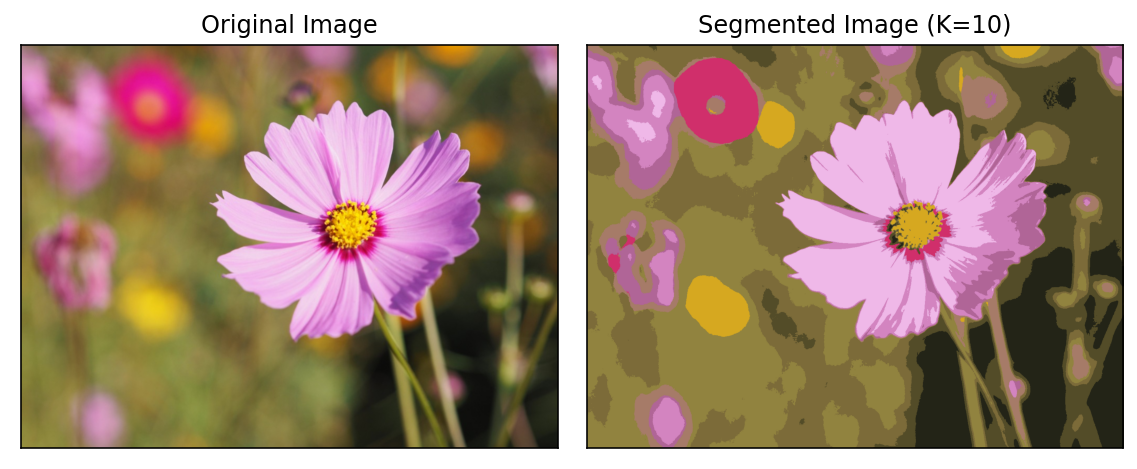

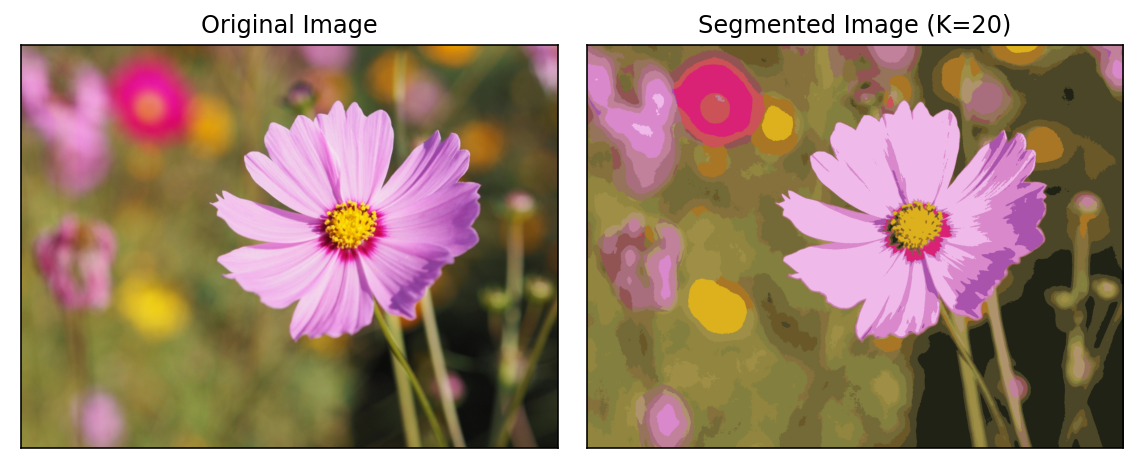

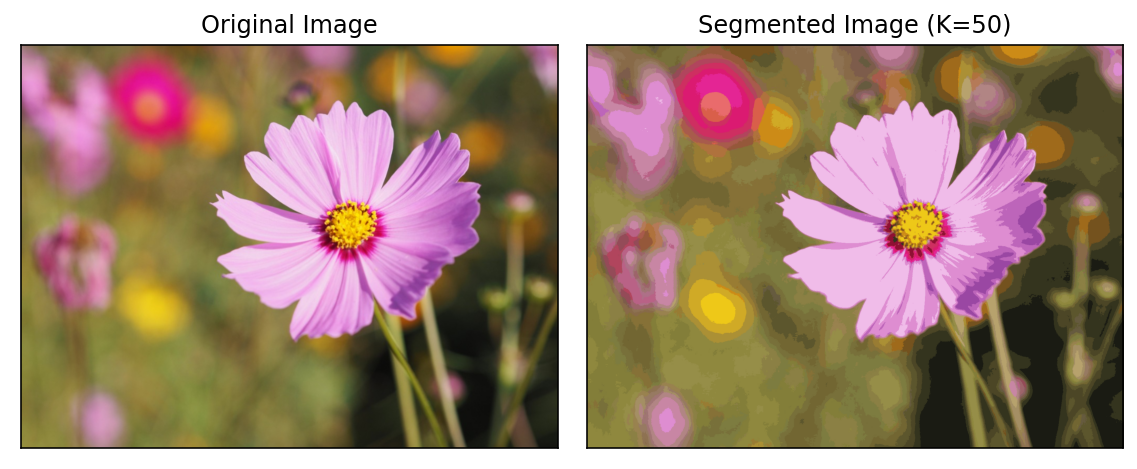

In [11]:
raw_image = io.imread('Data/Segmentation1.jpg')
segment(raw_image, 10)
segment(raw_image, 20)
segment(raw_image, 50)

## Fish

.......... .......... .......... 

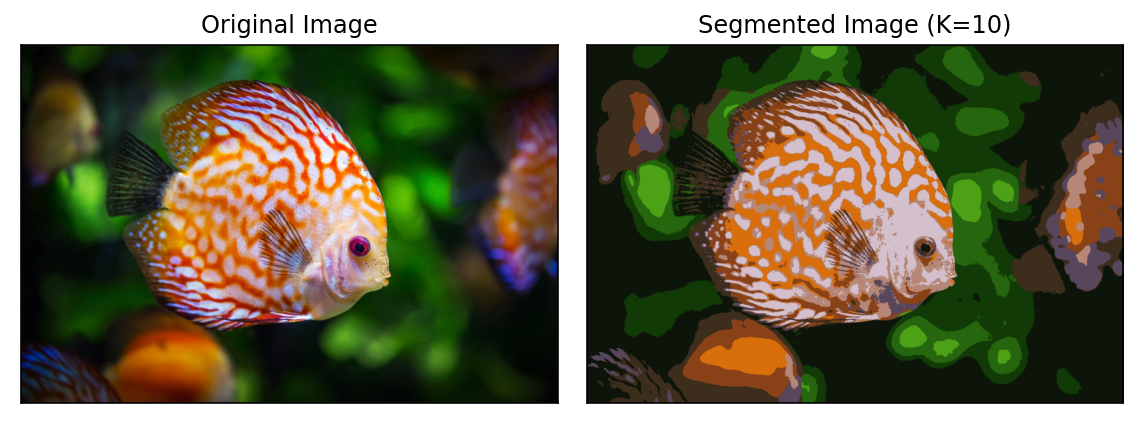

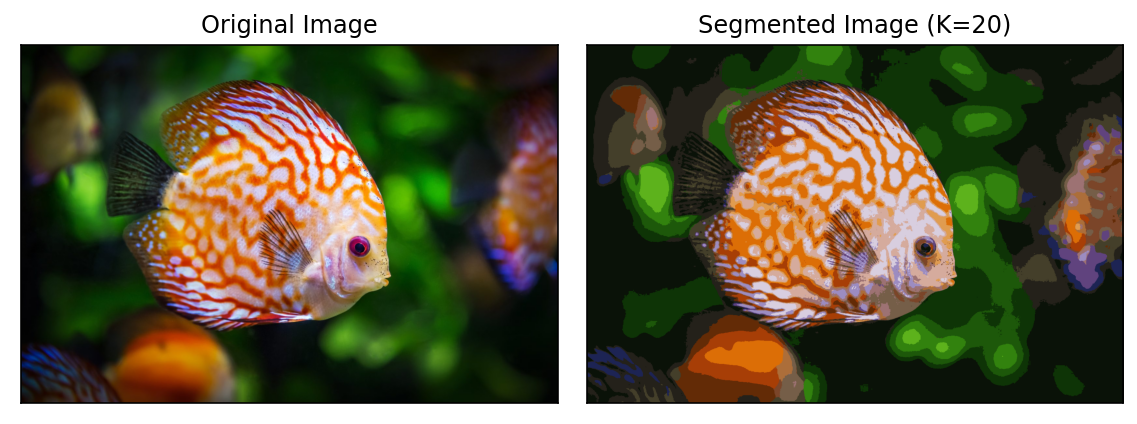

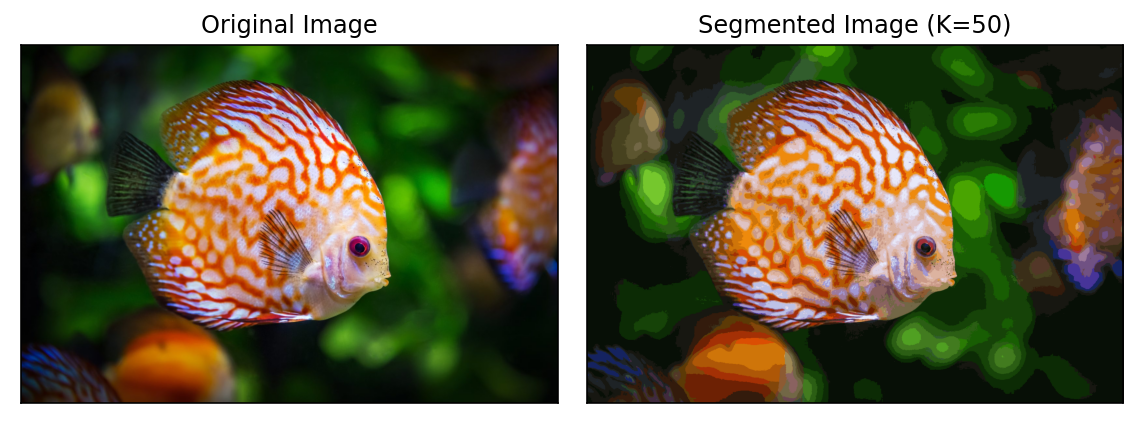

In [12]:
raw_image = io.imread('Data/Segmentation2.jpg')
segment(raw_image, 10)
segment(raw_image, 20)
segment(raw_image, 50)

## Sunset

.......... .......... .......... 

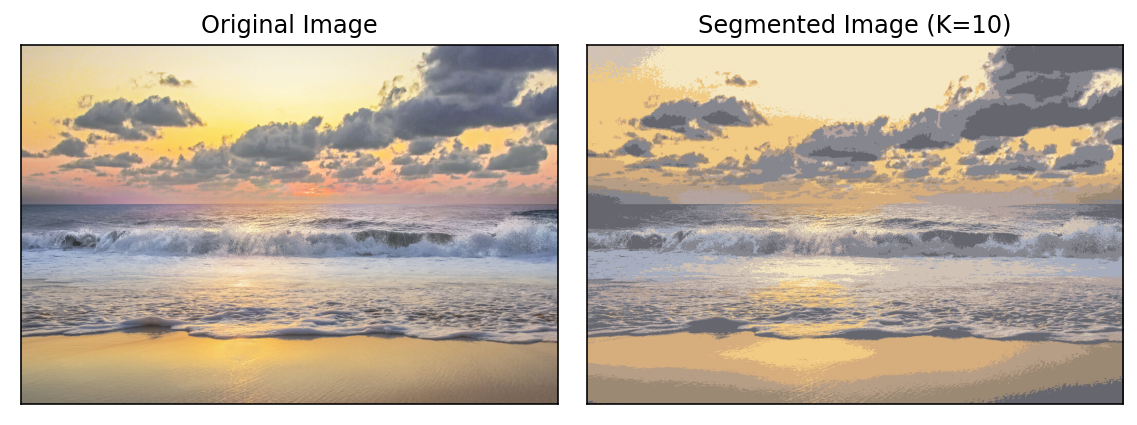

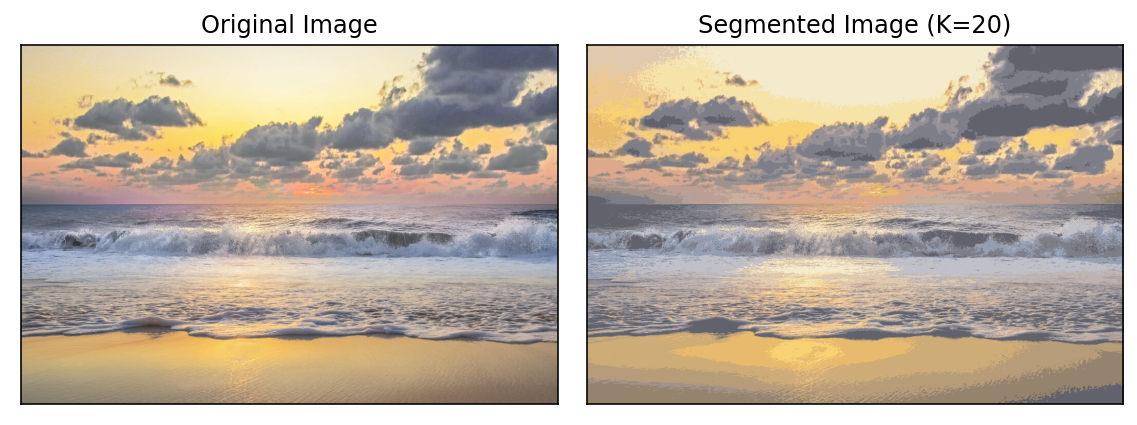

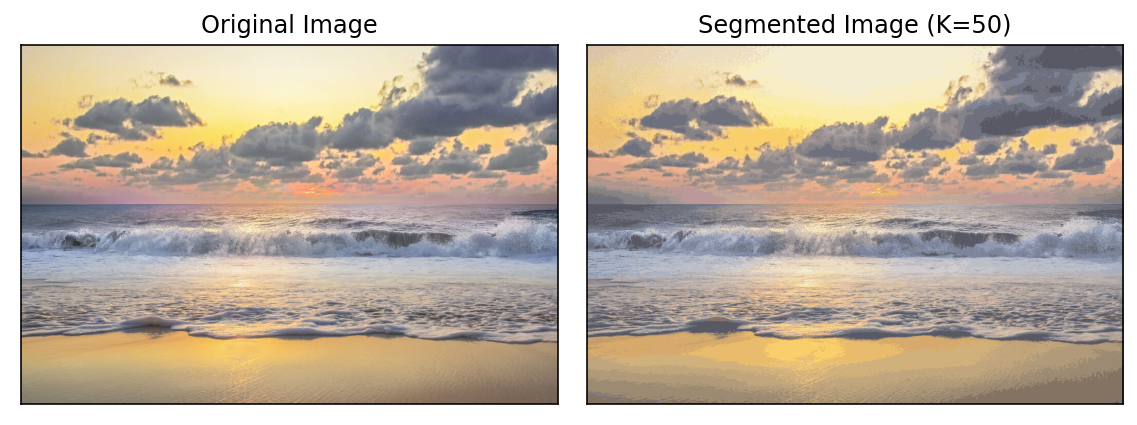

In [13]:
raw_image = io.imread('Data/Segmentation3.jpg')
segment(raw_image, 10)
segment(raw_image, 20)
segment(raw_image, 50)